In [1]:
# Set path to root and hide warnings
from setup import init_notebook
init_notebook()

# Other imports
import config
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Model
from myutils import load_json, store_json, load_pickle, store_pickle, print_all_stats
from tqdm import tqdm

# Project specific imports
from myutils import create_image

Using TensorFlow backend.


# MNIST - Transfer Learning Demo

In this tutorial, I will go step by step in the 'Transfer Learning' process. Briefly, the steps are:
1. Create a new network suitable for the first problem
2. Train the network on the labeled dataset for the first problem
3. Freeze the first network and exchange the bottom layer of `network_1` with that of `network_2` such that the model fits the data
4. Train the second network based on manually curated samples

## Create the Model

We first create `network_1`, which includes the both the shared network as the last categorical layer. The main goal of this first network is to categorize the handwritten digits (input images) into ten different classes, each representing another index (0..9).

In [2]:
%%capture

from transfer_learner import TransferLearner

model = TransferLearner(
    name='mnist',
    data_path='data/mnist/'
)

In [3]:
model.network_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, None, 3)     0         
_________________________________________________________________
conv1_layer1 (Conv2D)        (None, None, None, 16)    448       
_________________________________________________________________
conv2_layer1 (Conv2D)        (None, None, None, 16)    2320      
_________________________________________________________________
conv3_layer1 (Conv2D)        (None, None, None, 16)    2320      
_________________________________________________________________
max_pool (MaxPooling2D)      (None, None, None, 16)    0         
_________________________________________________________________
conv1_layer2 (Conv2D)        (None, None, None, 32)    4640      
_________________________________________________________________
conv2_layer2 (Conv2D)        (None, None, None, 32)    9248      
__________

In [4]:
model.print_stats()

transfer_learner_mnist_v00 - Parameters
	current_epoch : 0
	    is_frozen : False
	    network_1 : <keras.engine.training.Model object at 0x000002D7AE7B1B00>
	    network_2 : None
	       shared : <keras.engine.training.Model object at 0x000002D7AE7B15C0>



## Problem 1 - classify images

In a first stage, we will train `network_1` such that the CNNs are tuned well to work with the handwritten digits. For our problem, 5 epochs of training will be sufficient, as can be seen by the training accuracy.

### Train the model

In [5]:
# Train the model
model.train(epochs=5)

W0919 23:01:56.892623 22644 deprecation.py:323] From c:\users\ruben\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Saving the model... done, 1.6 seconds.


### Evaluate the model

Evaluation of the final model gives:

In [6]:
model.evaluate_1();

Predicting... done, 3.54 seconds.
Accuracy network 1:  0.979


### Visualize predictions

Next, I will create a short script to visualize the last softmax layer of the model, this to see how 'strongly' the model reacts to the corresponding input.

Input:


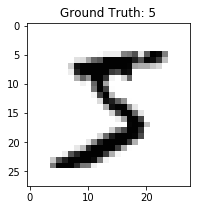

SoftMax activation layer:


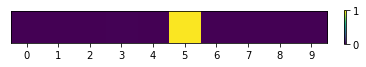

In [7]:
model.visualize_prediction_1(index=0)

## Problem 2 - identify odd numbers

For the second problem, the problem we're interested in, we want to identify odd numbers. First, to make sure all the trained knowledge from our first network remains as is, we will freeze those layers. This is already incoroprated into the script (see in `transfer_learner.py` the method `create_model_two`). An additional bottom layer which represents the output predictor of the binary classification problem is added as well.

In [8]:
model.create_model_two()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, None, 3)     0         
_________________________________________________________________
conv1_layer1 (Conv2D)        (None, None, None, 16)    448       
_________________________________________________________________
conv2_layer1 (Conv2D)        (None, None, None, 16)    2320      
_________________________________________________________________
conv3_layer1 (Conv2D)        (None, None, None, 16)    2320      
_________________________________________________________________
max_pool (MaxPooling2D)      (None, None, None, 16)    0         
_________________________________________________________________
conv1_layer2 (Conv2D)        (None, None, None, 32)    4640      
_________________________________________________________________
conv2_layer2 (Conv2D)        (None, None, None, 32)    9248      
__________

As can be seen, only the last weights are trainable ("`Trainable params: 129`" coincide perfectly with the number of parameters in the last layer, which are 128 connection weights and one bias weight). All the other parameters are frozen and thus non-trainable.

In [9]:
model.print_stats()

transfer_learner_mnist_v00 - Parameters
	current_epoch : 0
	    is_frozen : True
	    network_1 : <keras.engine.training.Model object at 0x000002D7AE7B1B00>
	    network_2 : <keras.engine.training.Model object at 0x000002D7D57E2D68>
	       shared : <keras.engine.training.Model object at 0x000002D7AE7B15C0>



## Problem 2 - manually train

Manually train the second model. This will happen in two phases:
1. First initialize the training set with a couple of training samples, a small batch of 32 samples will be manually curated before the model will learn
2. After every newly curated sample, the model will re-train. A plot of the sample distribution (number of samples the model predicts that are odd, and the number of samples the model predicts are even) will be given as well. Note that to evaluate the model properly, I've introduced a 'mapping' function, which functions as our evaluation ground truth.

### Initialize training

Manually curate 32 randomly sampled images.

Predicting... done, 4.51 seconds.
Accuracy network 2:  0.498


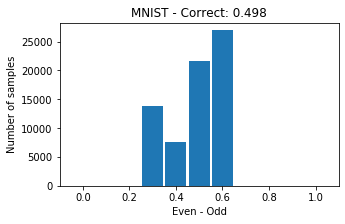

In [10]:
# Initial distribution
model.visualize_distribution()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  3.14s/it]



Saving the model... done, 1.79 seconds.
Predicting... done, 4.24 seconds.
Accuracy network 2:  0.396


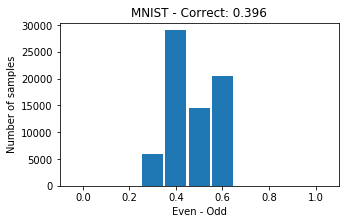

Continue?n


In [12]:
c = True
while c:
    model.curate_batch()
    model.train()
    model.visualize_distribution()
    c = input("Continue?")
    c = True if (c in ['yes', 'y', 'true', 'True']) else False

### Visualize predictions

Input:


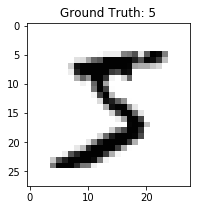

SoftMax activation layer:


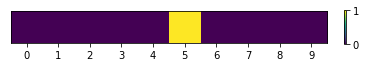

Connection weights between last two layers:


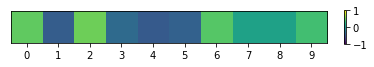

Sigmoid activation: value=0.41


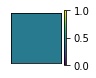

In [11]:
model.visualize_prediction_2(index=0)

### Model's final performance on the second problem

Curate one sample at a time, and after each new addition to the training set, the model is re-evaluated.

Predicting... done, 4.49 seconds.
Accuracy network 2:  0.396


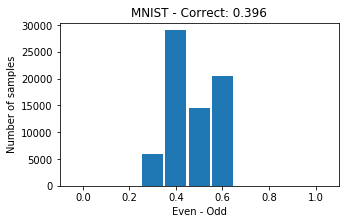

In [14]:
model.visualize_distribution()

Predicting... done, 4.02 seconds.
Accuracy network 2:  0.502


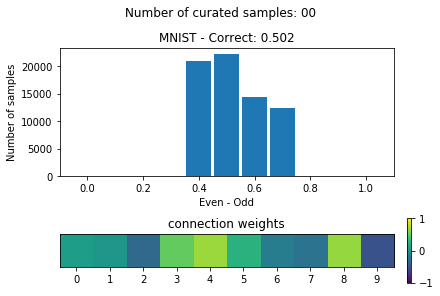

In [10]:
from images.create_gif import create_image_model_state
create_image_model_state(model)

In [16]:
while True:
    model.curate_batch()
    model.train()
    create_image_model_state(model)

Exception: Invalid input!